## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.morphology import remove_small_objects

from enum import Enum
from typing import Any, List, Literal

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

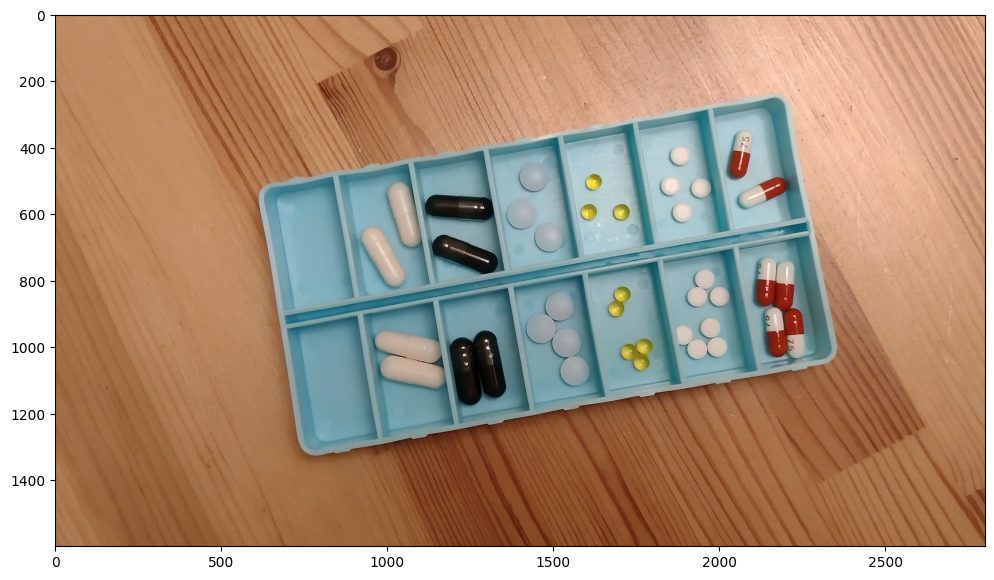

In [2]:
calib = cv2.imread('calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [3]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [48]:
class PillDetector:
    RGB = 'RGB'
    BGR = 'BGR'
    HSV = 'HSV'
    GRAY = 'GRAY'

    def __init__(self, input_color_space: Literal['BGR', 'RGB', 'HSV', 'GRAY'] ='BGR'):
        assert input_color_space in ['BGR', 'RGB', 'HSV', 'GRAY']
        self.__input_color_space = input_color_space
    
    @property
    def input_color_space(self):
        return self.__input_color_space
    
    def detect(self, src):
        ...
    
    def cropp_box(self, src: np.ndarray):
        image = src.copy()
        image = self.to_hsv(image)[..., 0].astype(np.uint8)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (300, 300))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = list(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
        x, y, w, h = cv2.boundingRect(contours[0])
        box_image = self.to_rgb(src[y: y + h, x: x + w])
        c = self.to_rgb(src.copy())
        c = cv2.GaussianBlur(c, (41, 41), 100.0)
        c[y: y + h, x: x + w] = box_image
        plt.imshow(c)
        plt.show()
        plt.imshow(box_image)
        plt.show()
        
    
    def __to(self, src: np.ndarray, target: str) -> np.ndarray:
        if self.__input_color_space == target:
            return src
        convertion_code = getattr(cv2, f'COLOR_{self.__input_color_space}2{target}')
        return cv2.cvtColor(src, convertion_code)
    
    def to_rgb(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.RGB)

    def to_bgr(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.BGR)
    
    def to_hsv(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.HSV)
    
    def to_gray(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.GRAY)

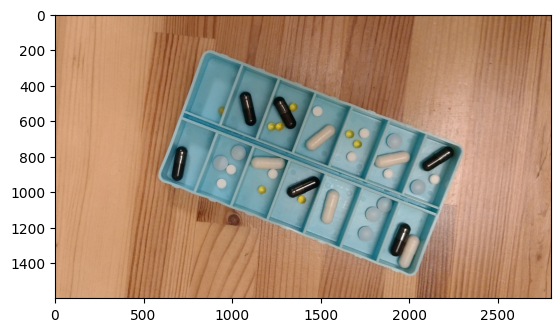

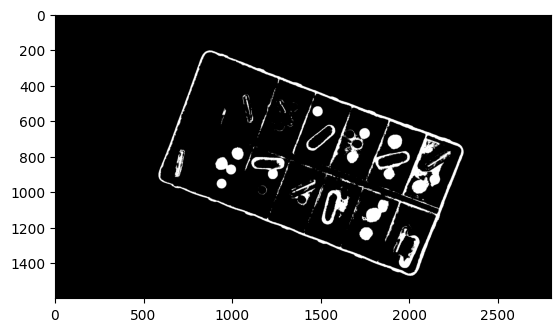

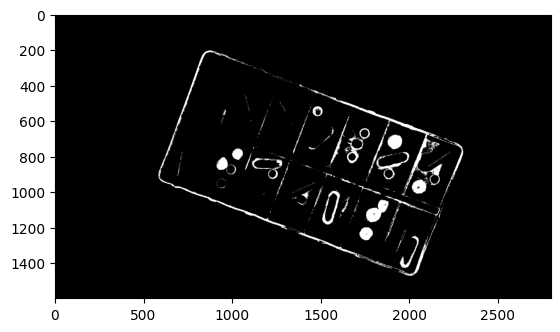

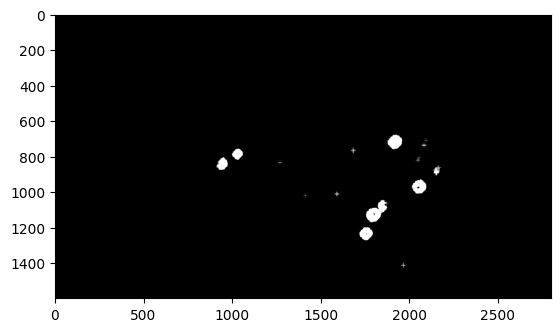

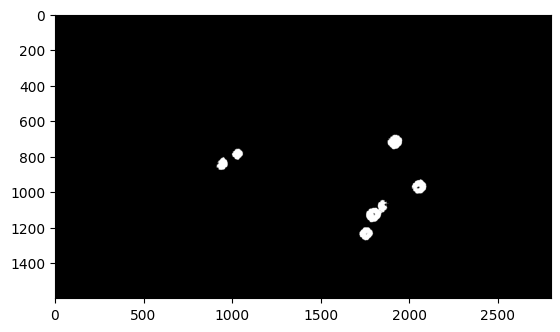

6


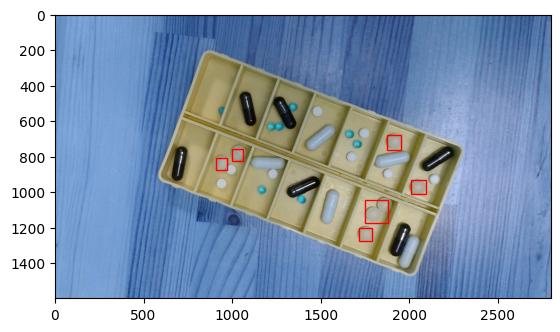

In [181]:
from matplotlib import patches


src = cv2.imread('calib.png')
src = cv2.imread('test_line.png')
src = cv2.imread('test.png')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.show()
assert src is not None

# img = src.copy()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.convertScaleAbs(img, alpha=3, beta=10)
# plt.imshow(img)
# plt.show()

img = src.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img = img[..., 1].astype(np.uint8)
th, img = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY_INV)
img = (img / 255).astype(bool)
plt.imshow(img, cmap='gray')
plt.show()

img = (cv2.inRange(src.copy(), (140, 140, 140), (190, 190, 190)) & img).astype(np.uint8) * 255
plt.imshow(img, cmap='gray')
plt.show()


kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (25, 25))
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(img, cmap='gray')
plt.show()

img = remove_small_objects(img > 0, min_size=2500)
plt.imshow(img, cmap='gray')
plt.show()

contours, _ = cv2.findContours(img.astype(np.uint8) * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = list(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
print(len(contours))
plt.imshow(src)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

PROBIO # duże białe kapsułki \
CARBON # duże czarne kapsułki - RGB, kanał G, threshold 30 \
KETO # niebieskie tabletki \
ESPU # małe żółte kapsułki \
BIOX # małe białe tabletki \
LINE # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

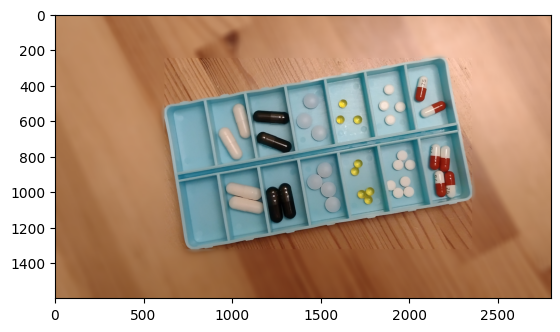

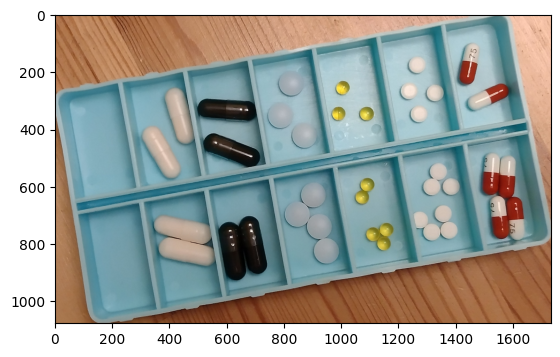

In [49]:
detector = PillDetector('BGR')
detector.cropp_box(calib)

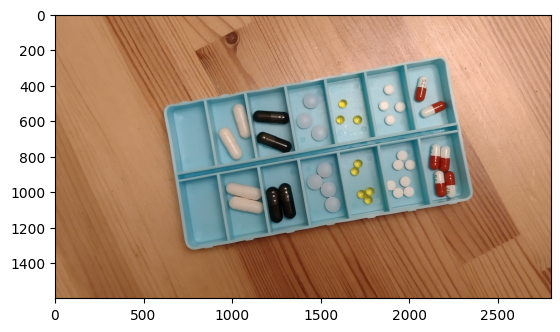

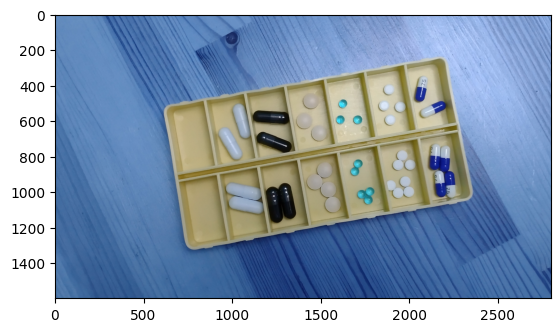

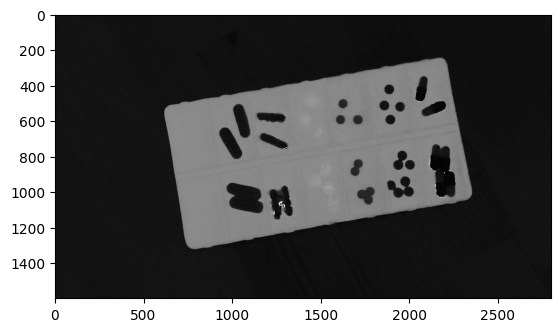

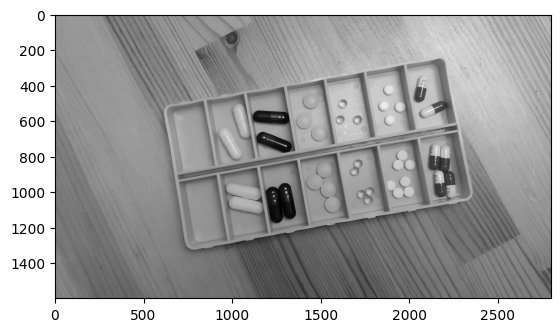

In [19]:
detector = PillDetector('BGR')
plt.imshow(detector.to_rgb(calib))
plt.show()
plt.imshow(detector.to_bgr(calib))
plt.show()
plt.imshow(detector.to_hsv(calib)[..., 0], cmap='gray')
plt.show()
plt.imshow(detector.to_gray(calib), cmap='gray')
plt.show()

In [4]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [5]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
    raise NotImplementedError

In [6]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    # ...
    plt.imshow(image)

In [ ]:
found = detect_objects(calib)
display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.